# Introduction

This notebook serves as a starting point for the data analysis of experinemt p2458 at MID. It shows how to 

* select a run (or measurement),
* plot statistical information on the intensity fluctations and the pointing,
* select trains based on certain criteria,
* load AGIPD data,
* define the setup and select q-regions,
* calculate and plot the azimuthally integrated intensity,
* calculate and plot correlation functions from evenly spaced pulses

# Imports and Function Definitions

**Packages To Load At the Beginning**

In [1]:
# lines starting with '%' are notebook magic functions
# %matplotlib notebook
%pylab
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

# standard python packages
import numpy as np
import pandas as pd
import scipy.integrate as integrate
from scipy.stats import gamma as gammafunc
from scipy.special import gamma
from scipy.stats import norm

# main analysis software can be installed by: pip install Xana
from Xana import Xana
from Xana.Xplot.niceplot import niceplot

# reading AGIPD data provided by XFEL
from extra_data import RunDirectory, stack_detector_data
from extra_geom import AGIPD_1MGeometry

# for plotting
from matplotlib import pyplot as plt
from matplotlib import patches
from matplotlib.colors import LogNorm
from matplotlib.collections import PatchCollection
from mpl_toolkits.axes_grid1 import make_axes_locatable

import seaborn as sns

Using matplotlib backend: agg
Populating the interactive namespace from numpy and matplotlib


ModuleNotFoundError: No module named 'Xana'

## Good to Know

Shows the docstring of a function or class by appending a question mark 

In [4]:
RunDirectory?

Run a cell without assertion to print the value of the variable or class


In [5]:
variable = 10
variable

10

You can install missing packages from within a jupyter notebook. Don't forget the "--user" flag. Otherwise, you will get a permission denied error.

In [161]:
!pip install cowsay --user

  Using cached https://files.pythonhosted.org/packages/d4/68/af23fbf90493044fc2ea83cd62923b9952c2d38eeeab83e0c016706bfbc8/cowsay-2.0.3-py2.py3-none-any.whl
  The script cowsay is installed in '/home/reiserm/.local/bin' which is not on PATH.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You are using pip version 18.0, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


You can execute shell commands by starting a line with an exclamation mark (!).

In [6]:
!pwd

/gpfs/exfel/data/user/reiserm/projects/proteins/mid-p2458/midtools


Set the plot style with seaborn

In [6]:
sns.set_context('notebook',)

## Helper Functions not Implemented in Xana, yet

In [ ]:
# calculating analytical formfactor of spherical nanoparticles
def F_sphere(q,R): return 3.*(np.sin(q*R)-q*R*np.cos(q*R))/(q*R)**3

def schulzfunc(R,mR,z): return ((z+1)/mR)**(z+1) * R**z/gamma(z+1) * np.exp(-(z+1)*R/mR)

def I_saxs(q, R, sld=(1,0), **kwarg):
    norm = 1
    for name in kwarg:
        norm *= kwarg[name]
    if type(R) == list or type(R) == tuple:
        z = (100/R[1])**2 - 1
        V = np.array([integrate.quad(lambda x: schulzfunc(x,R[0],z) * (4/3*np.pi*(x*1e-9)**3)**2 * 
                                     abs(F_sphere(qi,x))**2, 0, np.inf)[0] for qi in q])
        return (abs(sld[0]-sld[1])*1e20)**2 * V * norm /100
    else:
        return (abs(sld[0]-sld[1])*1e20)**2 * (4/3*np.pi*(R*1e-9)**3) * abs(F_sphere(q,R))**2 * norm / 100

In [ ]:
# shade ring on detector for manual calibration
def shade_wedges(ax, center, radii, alpha=0.6, cmap='inferno',):
    yl = ax.get_ylim()
    wedges = []
    r = radii
    nr = len(r)
        
    # Loop over data points; create box from errors at each point
    clrs = plt.get_cmap(cmap, nr)
    clrs = clrs(np.arange(nr))
    
    for ri in r:
        w = patches.Wedge(center, ri[0], 0, 360 , width=ri[1])
        wedges.append(w)

    # Create patch collection with specified colour/alpha
    pc = PatchCollection(wedges, facecolors=list(clrs), alpha=alpha,
                         edgecolor='k')

    # Add collection to axes
    lims = (ax.get_xlim(), ax.get_ylim())
    ax.add_collection(pc)
    ax.set_xlim(lims[0])
    ax.set_ylim(lims[1])
    
# add nice colorbar to plots
def add_colorbar(ax, im):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    colorbar(im, cax=cax)
    
# function to edit and display the AGIPD geometry in a simple way
def simple_geometry(image, quad_pos, ring_radius=None, ring_width=20, r=2000, vmin=None, vmax=None):
    
    if image.ndim == 4:
        image = image[0]
    
    geom = AGIPD_1MGeometry.from_quad_positions(quad_pos=quad_pos)
    d, (cy,cx) = geom.position_modules_fast(image)
    img = d

    # plot only the center part of the detector with radius r [pixels]
    dim = img.shape
    x1, x2 = ( max( cx-r, 0 ), min( cx+r, dim[1] ) )
    y1, y2 = ( max( cy-r, 0 ), min( cy+r, dim[0] ) )
    
    fig, ax = plt.subplots(figsize=(8,9))
    ax = plt.gca()
    ax.hlines(cy-y1, cx-x1 - 20, cx-x1 + 20, colors='r', linewidths=1)
    ax.vlines(cx-x1, cy-y1 - 20, cy-y1 + 20, colors='r', linewidths=1)

    img = d
    im = ax.imshow(img, origin='lower', cmap='magma', norm=mpl.colors.LogNorm(vmin, vmax))
    add_colorbar(ax, im)

    # shade a ring in pixel coordinates for manual alignment
    if bool(ring_radius) and bool(ring_width):
        shade_wedges(ax, (cx-x1,cy-y1), [(ring_radius, ring_width)], alpha=.2)

    plt.tight_layout()

    dist = geom.to_distortion_array()
    
    return (cy,cx), dist, geom

# Select a Run

In [9]:
!ls /gpfs/exfel/exp/MID/202001/p002458/scratch/example_data # this is actually a shell command

r0390  r0522


In [10]:
run_id =  522 # define the run number

You can choose between *raw*  and *processed* data by choosing the corresponding folder.

In [11]:
rundir = f'/gpfs/exfel/exp/MID/202001/p002458/scratch/example_data/r{run_id:04d}/'
run = RunDirectory(rundir)
run.info()

# of trains:    1435
Duration:       0:02:23.5
First train ID: 541834019
Last train ID:  541835453

16 detector modules (MID_DET_AGIPD1M-1)
  e.g. module MID_DET_AGIPD1M-1 0 : 512 x 128 pixels
  MID_DET_AGIPD1M-1/DET/0CH0:xtdf
  100 frames per train, up to 143500 frames total

1 instrument sources (excluding detectors):
  - SA2_XTD1_XGM/XGM/DOOCS:output

13 control sources:
  - MID_DET_AGIPD1M/CC/MON_0
  - MID_EXP_AGIPD1M/GAUGE/PG1
  - MID_EXP_AGIPD1M/PSC/HV
  - MID_EXP_AGIPD1M/TSENS/H1_T_EXTHOUS
  - MID_EXP_AGIPD1M/TSENS/H2_T_EXTHOUS
  - MID_EXP_AGIPD1M/TSENS/Q1_T_BLOCK
  - MID_EXP_AGIPD1M/TSENS/Q2_T_BLOCK
  - MID_EXP_AGIPD1M/TSENS/Q3_T_BLOCK
  - MID_EXP_AGIPD1M/TSENS/Q4_T_BLOCK
  - MID_EXP_AGIPD1M1/CTRL/MC1
  - MID_EXP_AGIPD1M1/CTRL/MC2
  - MID_EXP_SYS/TSYS/UTC-2-S4
  - SA2_XTD1_XGM/XGM/DOOCS



## Some statistical properties - Based on XGM Data

Based on the data from the X-ray gas monitor (XGM) the intensity and the pointing (the spatial fluctuations) of the X-ray beam can be investigated. Therefore, the data are loaded as a `pandas` dataframe using `extra_data`. A dataframe is simply a table with headings for each column.

In [12]:
# get data as pandas dataframe
df = run.get_dataframe(fields=[("*_XGM/*", "*.photonFlux"),])

# you can load multiple sources and keys at ones by extending the list of "fields"
# df = run.get_dataframe(fields=[("*_XGM/*", "*.photonFlux"), ("*_XGM/*", "*.i[xy]Pos")])

df.head(5) # this is how you display the first five rows of the dataframe 

SA2_XTD1_XGM/XGM/DOOCS/pulseEnergy.photonFlux
541834019                                     423.164551
541834020                                     423.164551
541834021                                     423.164551
541834022                                     423.164551
541834023                                     423.404663

### average intensity per train (average over single pulses)

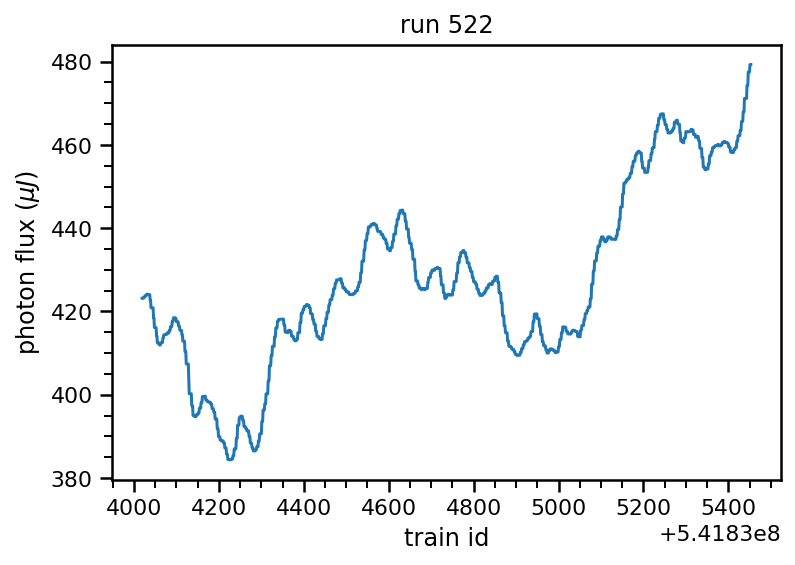

In [13]:
fig, ax = subplots() # make a figure 

df.plot(y=df.columns[0], ax=ax, label='photon flux', legend=False)
ax.set_xlabel('train id')
ax.set_ylabel('photon flux ($\mu J$)')
ax.set_title(f"run {run_id}")
ax.minorticks_on()

### Pulse Resovled Intensity

By specifying a differnt data source (or key) the pulse resolved data can be loaded.

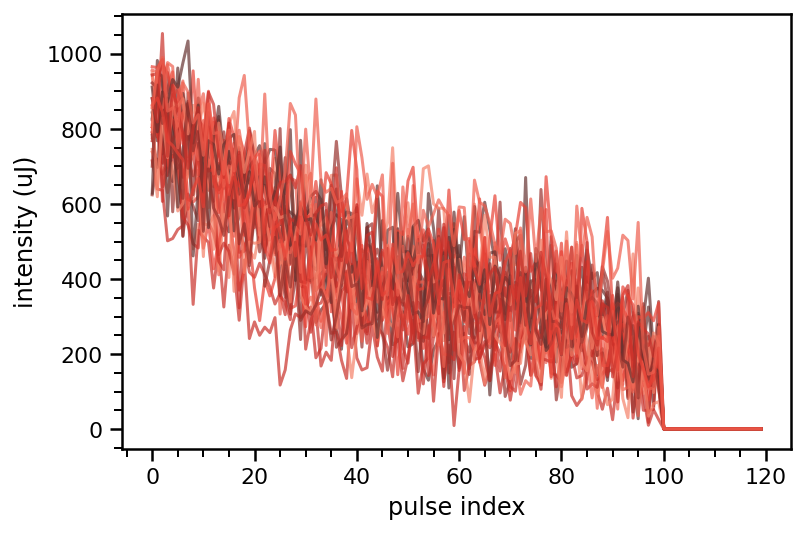

In [14]:
# the first argument is the data source, the second one the attribute 
arr = run.get_array('SA2_XTD1_XGM/XGM/DOOCS:output', 'data.intensityTD')

last_pulse = 120 # as not all memory cells contain data, we specify the last one to plot
train_step = 50 # we don't wanna plot the data of all trains; therefore, we specify a step size

pulse_intensities = arr[::train_step,:last_pulse]
train_ids = run.train_ids[::train_step] # get the corresponding train ids

with sns.color_palette('Reds_d'):
    plot(pulse_intensities.T, alpha=.7)
    xlabel('pulse index')
    ylabel('intensity (uJ)')

gca().minorticks_on()

We use pandas `rolling` function to calculate a running average. To plot each resampled train, we iterate over the array of pulse resolved intensity data and keep track of the train_id.

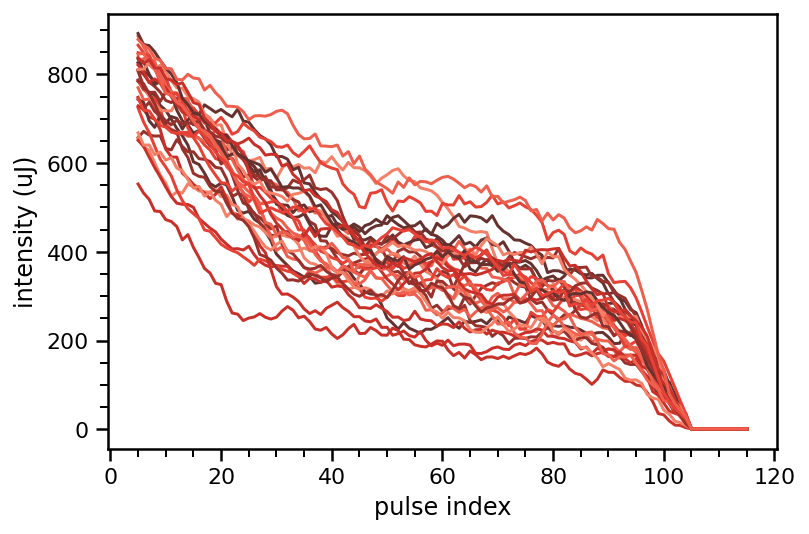

In [15]:
with sns.color_palette('Reds_d'):
    for train_id, pulses in zip(train_ids, pulse_intensities):
        pulse_df = pd.Series(pulses)
        
        # window is the interval that is averaged, center indicated that
        # the center of each interaval is used as the x coordinate 
        pulse_df = pulse_df.rolling(window=10, center=True).mean()  
        
        # plot the data
        pulse_df.plot()
        

xlabel('pulse index')
ylabel('intensity (uJ)')
gca().minorticks_on()   

### Investigate the Fluctuations

In addition to the pulse resolved intensities, we now also load the horizontal and vertical beam positions to study the pointing stability.

In [16]:
last_pulse = 100 # as not all memory cells contain data, we specify the last one to plot

# get train_ids
train_ids = np.array(run.train_ids) # the data are converted to numpy (np) arrays to allow certain operations
pulse_indices = np.arange(last_pulse)

# load intensities
I = run.get_array('SA2_XTD1_XGM/XGM/DOOCS:output', 'data.intensityTD')
I = np.array(I[:,:last_pulse])
I = I.flatten()

# load y-positions
y = run.get_array('SA2_XTD1_XGM/XGM/DOOCS:output', 'data.yTD')
y = np.array(y[:,:last_pulse])
y = y.flatten()

# load x-positions
x = run.get_array('SA2_XTD1_XGM/XGM/DOOCS:output', 'data.xTD')
x = np.array(x[:,:last_pulse])
x = x.flatten()

# the arrays are combined to a pandas DataFrame
run_idx = np.repeat(train_ids, pulse_indices.size)
d = {'x':x, 'y':y, 'I':I, 'id':run_idx}
df = pd.DataFrame(d)

In the next cell, pandas `groupby` feature is used to group the data based on their train_id. The `agg` function is used to calculate the mean and the standard deviation of the intensity and the standard deviation of the x and y positions.

In [17]:
agg_df =  df.groupby(by='id').agg({'I':['mean', 'std'], 'x':'std', 'y':'std'})

# show the 5 trains with the highest average photon flux
agg_df.nlargest(n=5, columns=('I','mean'))

I                     x         y
                 mean         std       std       std
id                                                   
541835437  690.028015  159.793884  0.404787  7.236414
541835430  651.830811  205.479874  0.476978  6.407861
541835431  644.664001  152.627869  0.403723  8.165463
541835134  637.735596  214.823151  0.651907  7.315187
541835438  634.142883  158.590149  0.410772  8.351281

The new DataFrame `agg_df` is used to plot the distributions of the pointing in x and y, $\sigma_x$ and $\sigma_y$, the average intensity per train, $\langle I\rangle$, and the intensity fluctuation within a train, $\sigma_I$. 

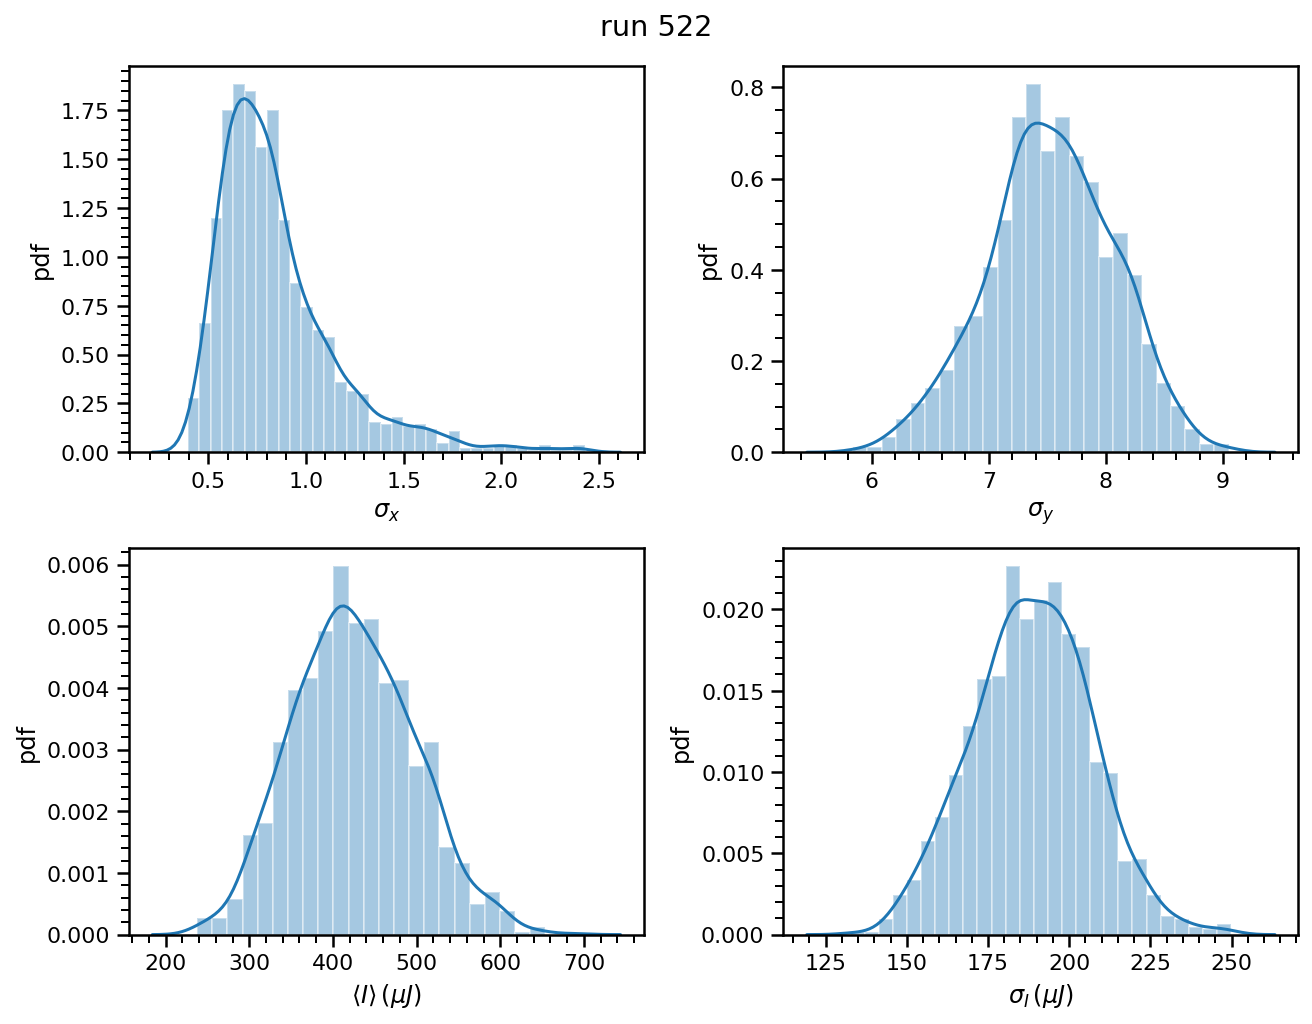

In [18]:
fig, axl = subplots(2,2, figsize=(9,7), constrained_layout=True)

keys = ['x', 'y', ('I', 'mean'), ('I', 'std')]
names = [r'$\sigma_x$', r'$\sigma_y$', r'$\langle I\rangle\,(\mu J)$', r'$\sigma_I\,(\mu J)$']

with sns.axes_style("white"):
    for key, name, ax in zip(keys, names, axl.flat):
        sns.distplot(agg_df[key], kde=True, ax=ax, axlabel=name)
        ax.set_ylabel('pdf')
        ax.minorticks_on()

plt.suptitle(f"run {run_id}");

Based on the histograms, we can define criteria to select only particular trains from the run.

**IMPORTANT**: Those values are arbitrary and you will have to change them.

In [19]:
cond1 = agg_df[('I', 'mean')] > 300
cond2 = agg_df[('I', 'std')] < 220
cond3 = agg_df[('x', 'std')] < 1.4
cond4 = agg_df[('y', 'std')] < 8

cond = cond1 & cond2 & cond3 & cond4 # combine the conditions
good_trains = agg_df[cond].index.values # select the trains that match all conditions

No we have an array of all the "good" trains. Let's plot the data of the selected trains together:

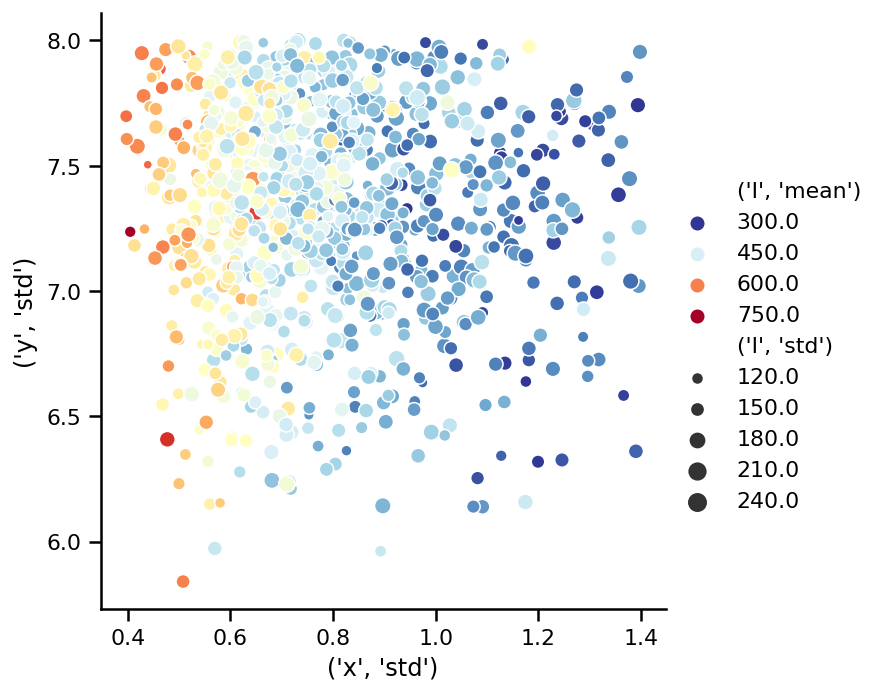

In [20]:
sns.relplot(x=('x','std'), y=('y', 'std'), hue=('I', 'mean'), size=('I','std'),
                data=agg_df[cond], palette='RdYlBu_r',);

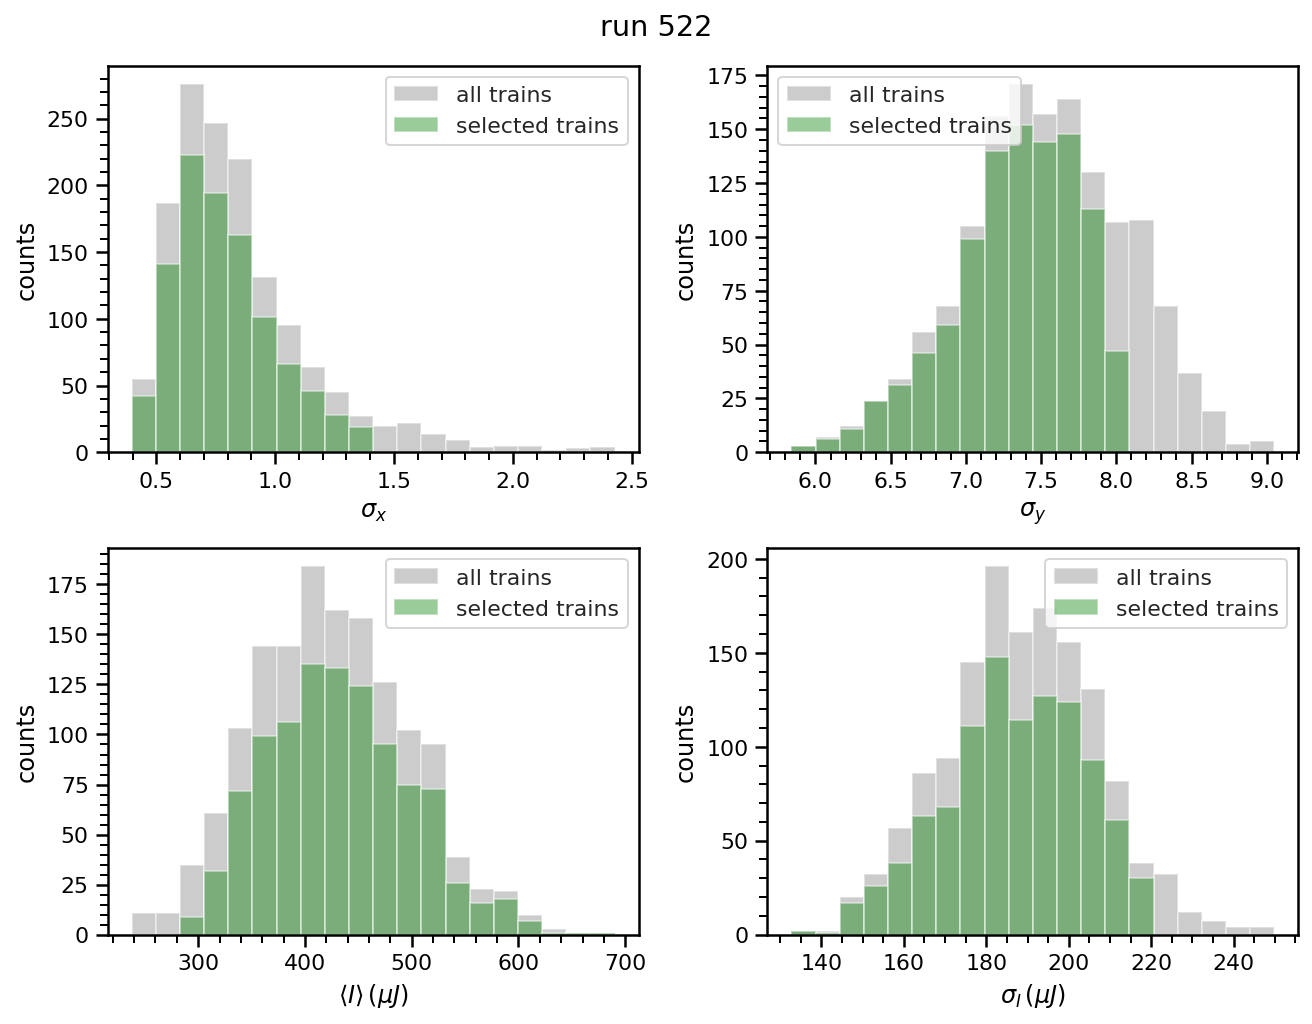

In [21]:
fig, axl = subplots(2,2, figsize=(9,7), constrained_layout=True)

keys = ['x', 'y', ('I', 'mean'), ('I', 'std')]
names = [r'$\sigma_x$', r'$\sigma_y$', r'$\langle I\rangle\,(\mu J)$', r'$\sigma_I\,(\mu J)$']

NBINS = 20 # number of bins

with sns.axes_style("white"):
    for key, name, ax in zip(keys, names, axl.flat):
        # bin the data to have the same bin edges for both plots
        bins = np.histogram(agg_df[key], bins=NBINS)[1]
        
        # plot all trains
        h = sns.distplot(agg_df[key], bins=bins, kde=False, ax=ax, axlabel=name, color='gray', label='all trains')
        
        # plot "good" trains in green
        sns.distplot(agg_df.loc[cond, key], bins=bins, kde=False, ax=ax, axlabel=name, color='g', label='selected trains')
        
        ax.set_ylabel('counts')
        ax.legend()
        ax.minorticks_on()
        
plt.suptitle(f"run {run_id}");

# AGIPD Data

trains can be selected based on their train_id (unique, increasing number) 
or by their index (starting by 0 at the first train of a run).
The corresonding selection methods `train_from_id` or `train_from_index` 
can be used.

In [22]:
train_id = good_trains[0] # select the first of the trains identified as "good"
tid, train_data = run.select('*/DET/*', 'image.data').train_from_id(train_id)

In [24]:
images = stack_detector_data(train_data, 'image.data') 
print(f'Shape of loaded data is {images.shape}')

Shape of loaded data is (100, 16, 512, 128)


We load the mask and invert it by using the "tilde". "good" pixels are 1 in the mask, bad ones 0.

In [25]:
mask = ~np.load('/gpfs/exfel/exp/MID/202001/p002458/scratch/masks/mask_cryo.npy') # load a mask

masked_pixels = sum(mask==0)/sum(mask==1) * 100
print(f"{masked_pixels:.2f}% of the pixels are masked.")

17.02% of the pixels are masked.


## Defining AGIPD Geometry

A simple way of calibrating the AGIPD, i.e., position the four quadrants correctly with respect to the direct beam, is to define the four corners of the quadrants. Their (x,y) coordinates are defined by a list of tubples, `quad_pos`. The `shade_wedges` function allows you to draw a ring with center (cx, cy) given the radius and the ring width. This makes it a little easier to see whether the quadrants are aligned properly. It has been built into `simple_geometry`.

If the relative distance of quadrants does not change but the detector position relative to the beam, use `dx` and `dy` to move all qaudrants.

By changing the parameter `r`, you can select the radius of the central section of the detector that is plotted.

`simple_geometry` returns the beam center, a distortion map, useful if you want to use pyFAI, and the `karabo_data` geometry.

In [27]:
avr_image = images.mean(0) # average all images of the train

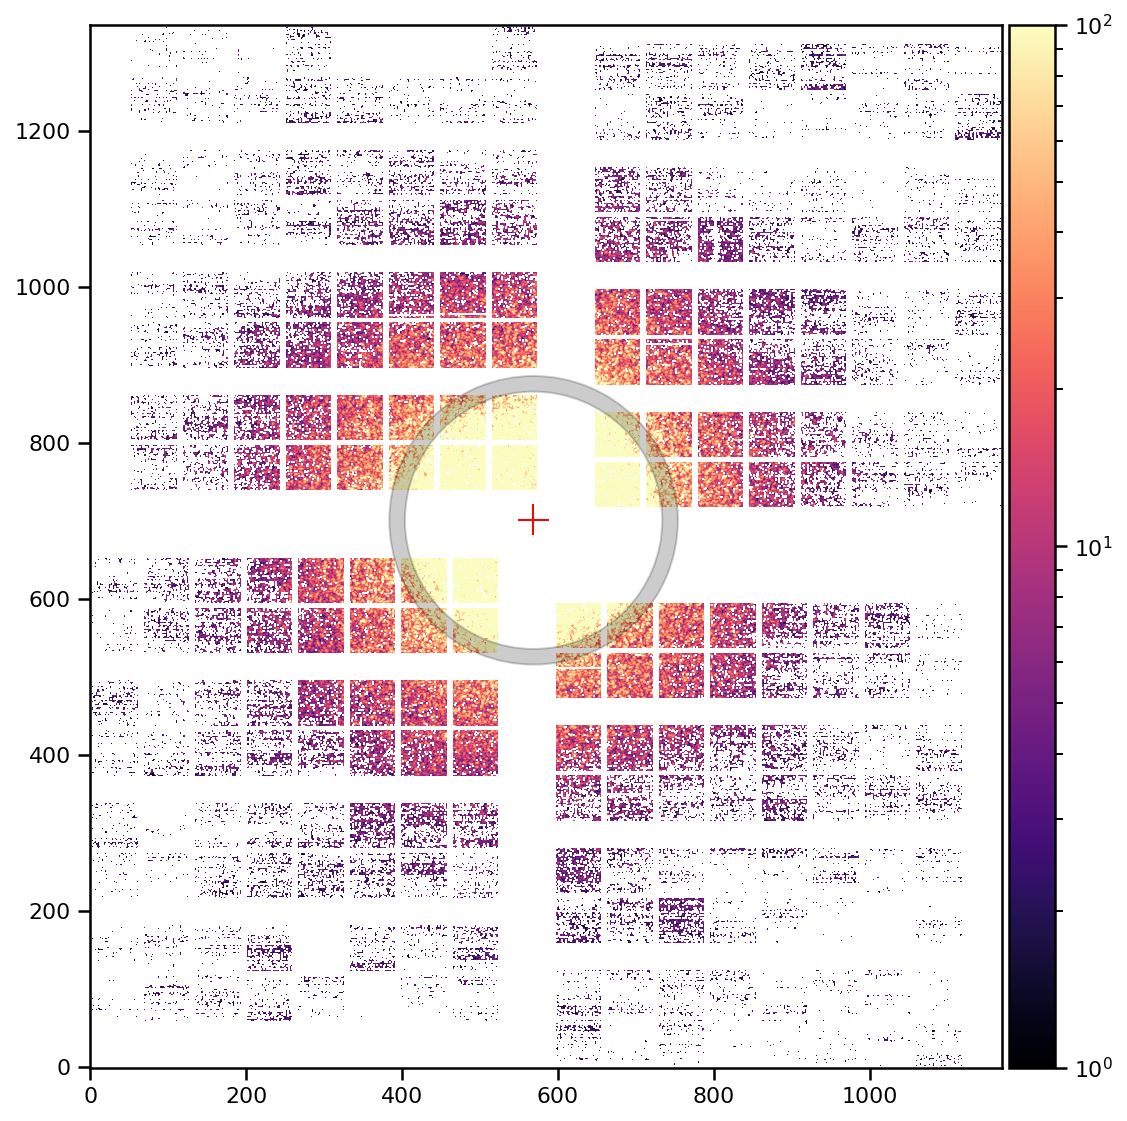

In [28]:
# define corners of quadrants. 
dx = -18
dy = -15
quad_pos = [(-500+dx, 650+dy),
           (-550+dx, -30+dy),
           (570+dx, -216+dy),
           (620+dx, 500+dy)] 

# ring radius and width for shaded area
ring_radius = 185
ring_width = 20

# section of detector to plot 
radial_section = 800


avr_image[mask==0] = np.nan
# use image and quad_pos for manual calibration
(cy,cx), dist, geom = simple_geometry(avr_image, quad_pos,
                                      ring_radius,
                                      ring_width,
                                      radial_section,
                                      vmin=1, vmax=100) # vmin and vmax can be set to modify the colorscale

## Define the Setup Parameters

In order to define your setup you need to know the sample-detector distance in meters and the wavelength of the x-rays in Angstrom. The beam center `ctr=(cy, cx)` is taken from your definition of the geometry (see above). Be a little careful with the way the center is defined. In the `karabo_data` geometry, the first coordinate is `y`, the second is `x`, but the setup class expects first `cx` and then `cy`.

Set the sample-detector distance in meters and the wavelength, too.

In [29]:
ENERGY = 8.8 # in keV
DISTANCE = 8 # in m

xana = Xana(detector='agipd1m', maskfile='')
xana.setup.make(distance=DISTANCE, center=(cx, cy), wavelength=12.38/ENERGY)
# geom = AGIPD_1MGeometry.from_crystfel_geom("/gpfs/exfel/exp/MID/202001/p002458/scratch/geoms/geo_assembled_3a.geom")
# dist = geom.to_distortion_array()
xana.setup.detector.set_pixel_corners(dist)
xana.setup.update_ai();

Mask file not found. Continuing with no pixel masked.


In [30]:
xana.mksavdir('./')
xana.savesetup('test')

Changing savdir to:
	/gpfs/exfel/data/user/reiserm/projects/proteins/mid-p2458/midtools/
Try loading database:
	/gpfs/exfel/data/user/reiserm/projects/proteins/mid-p2458/midtools/Analysis_db.pkl
	...loading database failed.
File exists. Save anyway? (No/Yes)	yes

Results saved to:
	/gpfs/exfel/data/user/reiserm/projects/proteins/mid-p2458/midtools/setup_test.pkl


##### Reshape Mask (just to be sure)

In [36]:
mask = mask.reshape(16,512,128) # wrong array shapes common errros
avr_image[mask==0] = np.nan

##### Get the q-Map

`xana.setup` provides you with the momentum transfer values of each pixel. Since it is based on pyFAI, which can only deal with 2D detectors, you have to reshape the q matrix from shape (8192=16x512, 128) to (16, 512, 128).

In [37]:
qmap = xana.setup.ai.array_from_unit(unit='q_nm^-1');
print(f"the shape of the q map is {qmap.shape}")

qr = qmap.reshape(16,512,128);
print(f"after reshaping {qr.shape}")

the shape of the q map is (8192, 128)
after reshaping (16, 512, 128)


When you have the q-map, you can simply call the `position_modules_fast` function from `extra_data` to reconstruct an image.

In [38]:
image_2d, center = geom.position_modules_fast(avr_image)
qmap_2d, center = geom.position_modules_fast(qr)

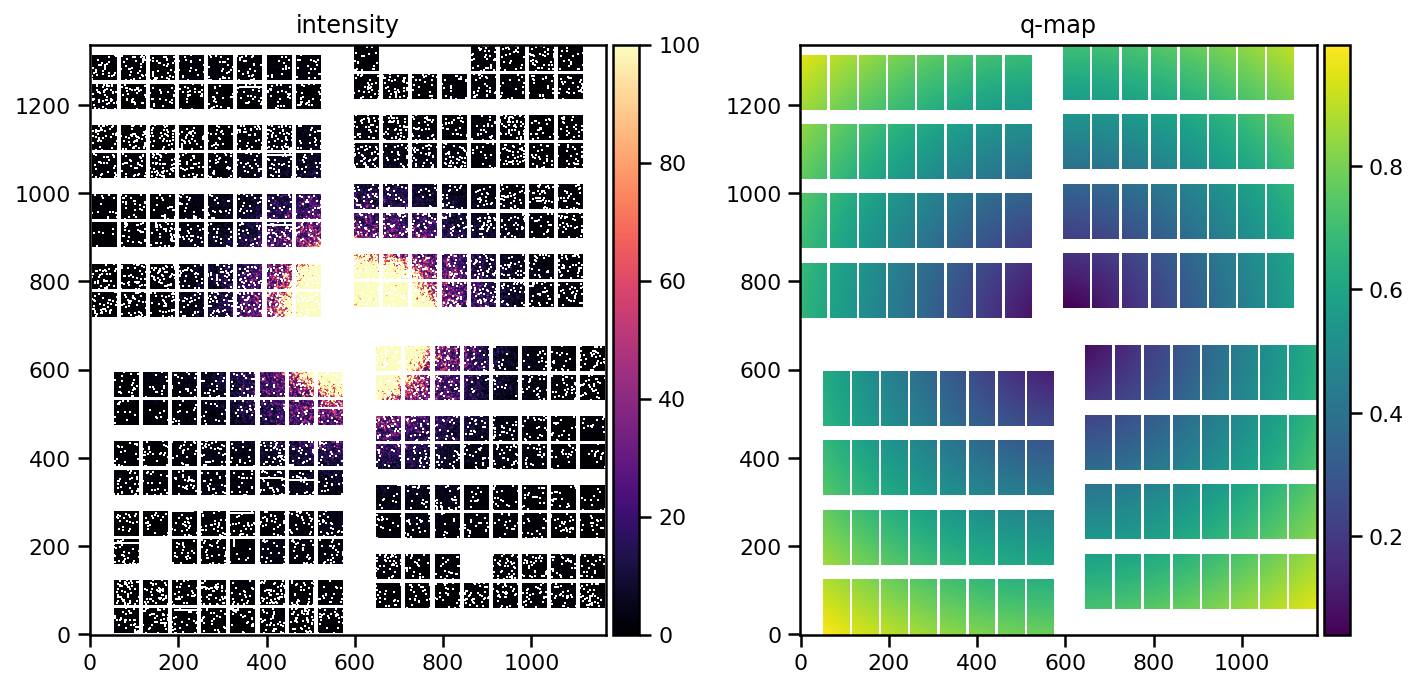

In [39]:
fig, ax = subplots(1, 2, figsize=(10,5)) # create figure with 2 axes

# plot image 
im = ax.flat[0].imshow(fliplr(image_2d), origin='lower', vmin=0, vmax=100, cmap='magma')
add_colorbar(ax.flat[0], im)
ax.flat[0].set_title('intensity')
ax.flat[0].grid(0)

# plot dq which is the q-map
im = ax.flat[1].imshow(fliplr(qmap_2d), origin='lower',)
add_colorbar(ax.flat[1], im,)
ax.flat[1].set_title('q-map')
ax.flat[1].grid(0)

# align plots
tight_layout()

## Azimuthal Integragtion 

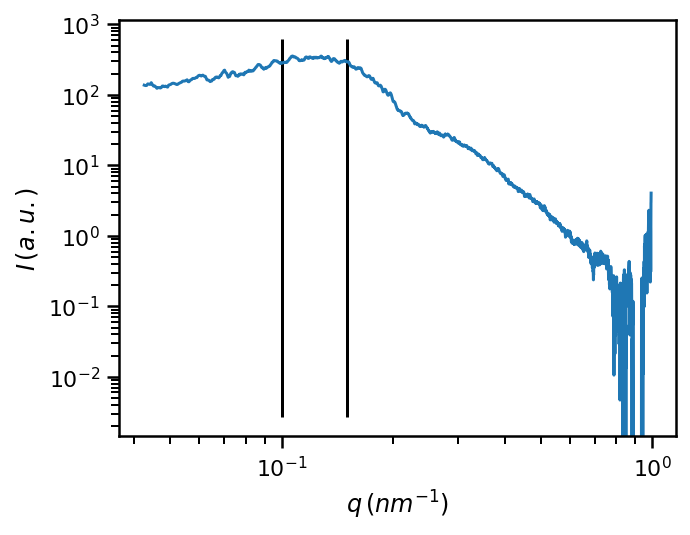

In [31]:
q_min = 0.1
q_max = 0.15

# aziumthal integration
q, I = xana.setup.ai.integrate1d(avr_image.reshape(8192,128), 3000, 
                        mask=~(mask.reshape(8192,128).astype('bool')), unit='q_nm^-1')

# plotting
fig, ax = plt.subplots(figsize=(5,4))
loglog(q,I)

xlabel('$q\, (nm^{-1})$')
ylabel('$I\, (a.u.)$')


ylim = gca().get_ylim()
vlines([q_min, q_max], ylim[0], ylim[1])

tight_layout()

## Speckle Contrast

Select all pixels in a certain q region from q_min to q_max. Keep in mind that the shape of image is (16, 512, 128). The condition `&mask` selects only pixels that have not been masked. The mask is an array of shape (16, 512, 128) where all "good" pixels are set to 1 and all bad/masked pixels are set to 0. 

In [46]:
q_min = 0.1
q_max = 0.15

pulse_number = 9 # pulses are in cell 1 to 10

# make sure that the 'images' array has not been modified
pix = images[pulse_number].copy() 
pix[mask==0] = np.nan

qr = qmap.reshape(16,512,128)
mask = mask.reshape(16,512,128)

pix = pix[(qr>q_min) & (qr<q_max) & (mask==1)]
pix = pix[pix>=0]

The intensity distribution of a speckle pattern can be described by a Gamma-Distribution 

$$P(I)_{M,\langle I\rangle}=\frac{M^{M}\,I^{M-1}\,e^{-M\,I\,/\langle I\rangle}}{\langle I\rangle^M\,\Gamma(M)}\,.$$

$I$ is the intensity, $\langle I\rangle$ the mean intensity and $M=\beta^{-1}$ is the mode number or the reciprocal speckle contrast, $\beta$. 

Since $\beta$ is the normalized variance of the Gamma-Distribution it can be estimated directly from the data.

$$\beta = \frac{var(I)}{\langle I\rangle^2}$$

For low intensity speckle patterns, you have to consider the Poisson-Gamma distribution and subtract one over the mean number of phontons, but that is the beginning of a different story. 
 
Both methods can be applied to our data as follows:

***from the normalized variance***

In [47]:
speckle_contrast = var(pix)/mean(pix)**2
print('The speckle contrast from the normalized variance', speckle_contrast.round(4))

The speckle contrast from the normalized variance 0.6116


***from fitting the histogram with a Gamma Distribution***

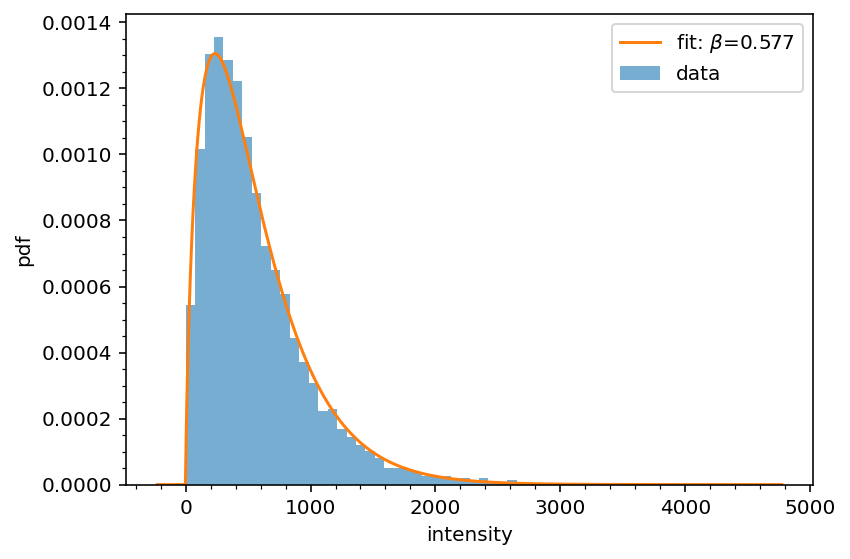

In [48]:
figure()

hist(pix, 60, density=True, alpha=.6)

xlim = gca().get_xlim()
xf = np.linspace(xlim[0],xlim[1],1000)
gamma_par = gammafunc.fit(pix, floc=0) # fit gamma distribution to data
yf = gammafunc.pdf(xf, *gamma_par) # calculate gamma pdf for plotting

plot(xf, yf)
xlabel('intensity')
ylabel('pdf')
legend([ r'fit: $\beta$={:.3f}'.format(1/gamma_par[0]), 'data'])
gca().minorticks_on()
tight_layout()

# X-Ray Photon Correlation Spectroscopy

Import the XPCS module `pyxpcs`

In [49]:
from Xana.XpcsAna.pyxpcs3 import pyxpcs

In [50]:
qr_tmp = qr.reshape(8192,128)
mask_2d = mask.reshape(8192,128)

# ROI 1
q_min = 0.14
q_max = 0.16
roi1 = np.where((qr_tmp>q_min) & (qr_tmp<q_max) & mask_2d)

# ROI 2
q_min = 0.16
q_max = 0.18
roi2 = np.where((qr_tmp>q_min) & (qr_tmp<q_max) & mask_2d)

# ROI 3
q_min = 0.18
q_max = 0.20
roi3 = np.where((qr_tmp>q_min) & (qr_tmp<q_max) & mask_2d)

# combine ROIs to list
roi_list = [roi1, roi2, roi3]
roi_q_values = [np.mean(qr_tmp[roi]) for roi in roi_list]

---

This part has been added. We import pickle and save the list of ROIs to load it with another notebook.

In [35]:
import pickle

In [54]:
pickle.dump({"rois_2d":roi_list_2d, "rois_3d":roi_list_3d}, open('./rois_01.pkl', 'wb'))

---

This is another way of creating a list of regions of interst:

In [52]:
q_min = 0.095
q_max = 0.16
qarr = np.arange(q_min,q_max,.01)

roi_list_2d = [np.where((qr_tmp>qi) & (qr_tmp<qf) & mask_2d) for qi,qf in zip(qarr[:-1],qarr[1:])]
roi_list_3d = [np.where((qr>qi) & (qr<qf) & mask) for qi,qf in zip(qarr[:-1],qarr[1:])]

Calculate correlatino functions for train ids in `good_train` array

In [52]:
cl = []
train_ids = good_trains[:10]
for i, train_id in enumerate(train_ids):
    # load the data
    tid, train_data = run.select('*/DET/*', 'image.data').train_from_id(train_id)
    data = stack_detector_data(train_data, 'image.data') 
    
    # reshape to be used by pyxpcs
    xpcs_data = data.reshape(-1,8192,128)
    
    # run the correlator and append the results to the 'cl'-list
    cl.append(pyxpcs(xpcs_data, roi_list, dt=440e-9, mask=mask_2d, norm='symmetric', twotime_par=0))

Number of images is: 100
shape of image section is: [8192, 128]
Number of ROIs:  3
Using 1 processes.
Number of registers is 4 with 40 total correlation points.
[============================================================] 100.0%..
Finished calculating correlation functions.
Start calculating TRC and Chi4...
Elapsed time: 0.03 min
Elapsed time for correlate: 0.03 min
Elapsed time for TRC and Chi4: 0.00 min
Number of images is: 100
shape of image section is: [8192, 128]
Number of ROIs:  3
Using 1 processes.
Number of registers is 4 with 40 total correlation points.
[============================================================] 100.0%..
Finished calculating correlation functions.
Start calculating TRC and Chi4...
Elapsed time: 0.03 min
Elapsed time for correlate: 0.03 min
Elapsed time for TRC and Chi4: 0.00 min
Number of images is: 100
shape of image section is: [8192, 128]
Number of ROIs:  3
Using 1 processes.
Number of registers is 4 with 40 total correlation points.
[================

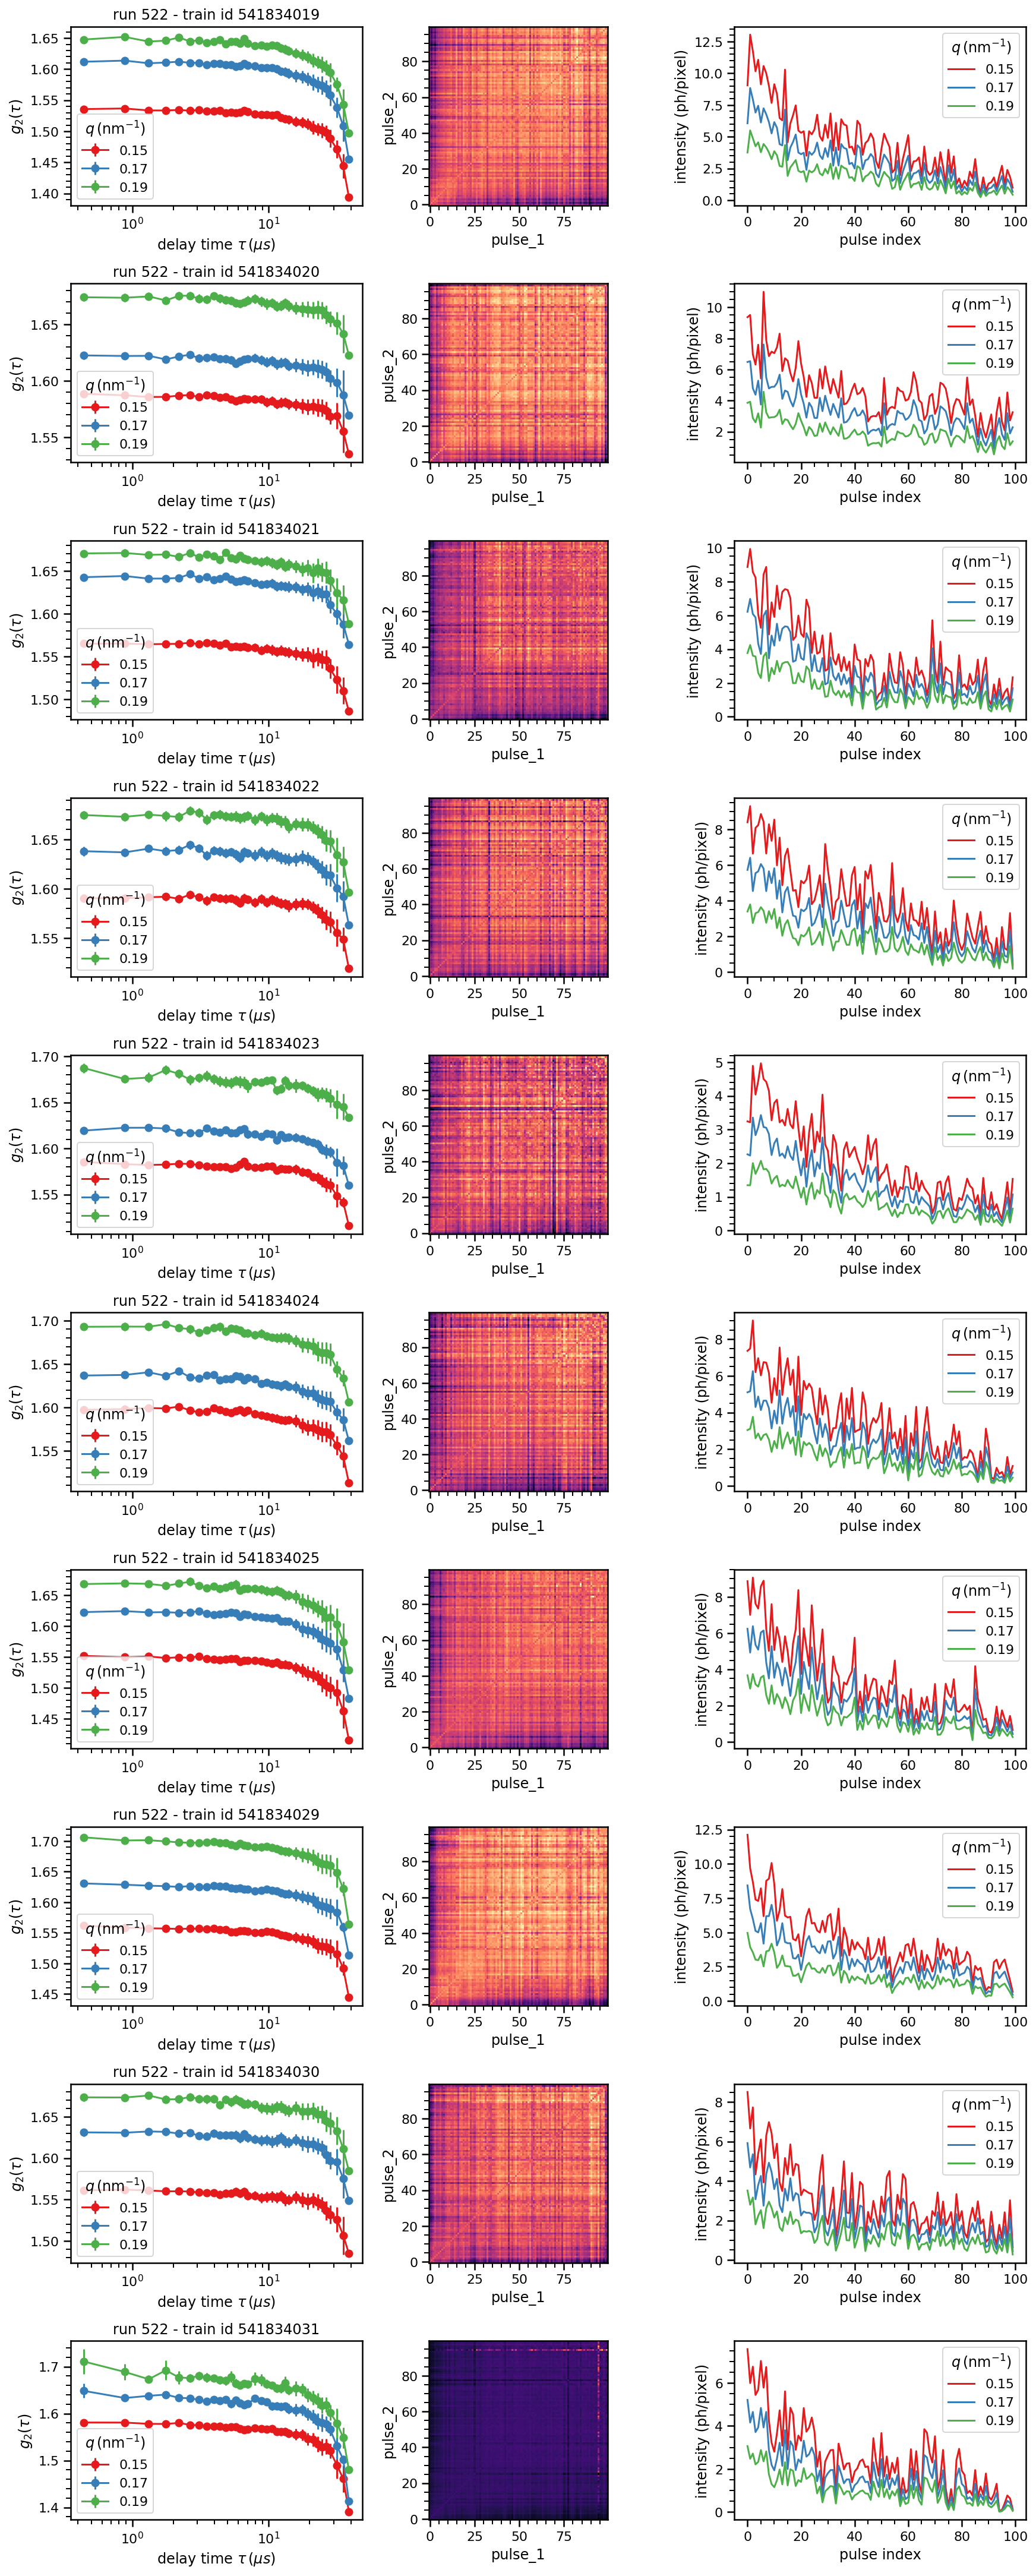

In [55]:
PHOTONS_PER_ADU = 62

fig, ax = subplots(len(cl) ,3, figsize=(12,3*len(cl)), constrained_layout=True)
ax = ax.flatten()
colors = sns.color_palette('Set1')
    
#iterate over the list 'cl' that contains the pyxpcs results for each train
for j, c in enumerate(cl):
    g2 = c['corf']
    dg2 = c['dcorf']

    axi = ax[3*j:3*j+3] # select the axes to plot

    # iterate over each roi and plot the correlation function
    for i in range(len(roi_list)):
        color = colors[i]
        qbin = roi_q_values[i]

        # plot g2
        axi[0].errorbar(g2[1:,0]*1e6, g2[1:,1+i], yerr=dg2[1:,1+i], fmt='o-', 
                        color=color, label=f'${qbin:.2f}$')
        axi[0].set_xscale('log')
        axi[0].set_xlabel(r'delay time $\tau\,(\mu s)$')
        axi[0].legend(title="$q\\,(\\mathrm{{nm}}^{{-1}})$")
        axi[0].set_title(f'run {run_id} - train id {train_ids[j]}')
        axi[0].set_ylabel(r'$g_2(\tau)$')
        axi[0].minorticks_on()

        # plot two-time correlation function
        axi[1].imshow(c['twotime_corf'][0], origin='lower', cmap='magma')
        axi[1].set_xlabel(r'pulse_1')
        axi[1].set_ylabel(r'pulse_2')
        axi[1].minorticks_on()


        # plot average intensity per pulse
        axi[2].plot(c['trace'][:,i]/PHOTONS_PER_ADU,color=color, 
                              label=f'${qbin:.2f}$')
        axi[2].set_ylabel('intensity (ph/pixel)')
        axi[2].set_xlabel('pulse index')
        axi[2].legend(title="$q\\,(\\mathrm{{nm}}^{{-1}})$")
        axi[2].minorticks_on()